In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
#file = ROOT.TFile.Open("4h_copy_ratio_FR.root")
file = ROOT.TFile.Open("run2_305stop.root")
#direc = file.Get("QFillByFillAnalyzerDB")
#file = ROOT.TFile.Open("run2_4hcopy_ratioFR_symm_cov_mat_test.root")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             tau_2cbo = 0.0,
             omega_2cbo = 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [6]:
p_init=[ 2.28839835e-01, -4.45413571e+01,  4.01442008e+00,  2.41430346e-03,
        2.56211558e+05,  2.34054617e-03,  5.71971712e+00,  6.95362408e-04,
       -5.53382699e-01, -6.94398884e-05,  2.82014933e+00,  2.10309288e-04,
        1.57958584e+05,  1.39300796e-02,  5.89626967e+00, -1.39104791e-03,
        2.84976961e+04,  1.40382363e-02,  1.19233527e+00,  1.20158793e-04,
        1.44435676e+05,  4.68963920e-03,  3.09422838e+00]

In [7]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

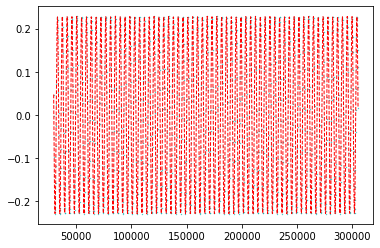

In [8]:
# Plot the noisy exponential data
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars2), linestyle='--', linewidth=1, color='red')
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [9]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov2))
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars2))/y_err

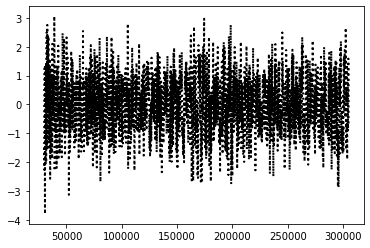

In [10]:
# Plot the noisy exponential data
plt.plot(x_val, res, linestyle='dotted', linewidth=2, color='black')
#plt.xlim([100000,150000])

In [11]:
pars2

array([ 2.28860664e-01, -4.45540016e+01,  4.01416909e+00,  2.29985163e-03,
        2.53379874e+05,  2.34041259e-03,  5.67001939e+00,  8.28980263e-04,
       -6.57944061e-01, -8.41984694e-05,  2.62785428e+00,  1.96821096e-04,
        1.76466889e+05,  1.39296763e-02,  5.89683389e+00, -1.45442019e-03,
        2.78583630e+04,  1.40374319e-02,  1.13967847e+00,  1.20954716e-04,
        1.40036026e+05,  4.68888463e-03,  3.07157893e+00])

In [12]:
stdevs

array([8.89110548e-06, 4.91440456e-01, 7.50512043e-05, 2.52136243e-05,
       8.48397427e+03, 1.32221880e-07, 1.09744313e-02, 7.60253741e-05,
       9.09942822e-02, 7.60416304e-05, 9.18425222e-01, 3.13352847e-05,
       5.73405845e+04, 1.84502122e-06, 1.59728203e-01, 2.18612911e-04,
       2.63739538e+03, 3.40030151e-06, 1.50623916e-01, 3.20858255e-05,
       7.34403094e+04, 3.73713618e-06, 2.64251077e-01])

In [13]:
fou=abs(np.fft.fft(res))

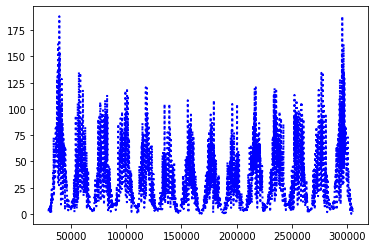

In [14]:
plt.plot(x_val, fou, linestyle='dotted', linewidth=2, color='blue')

In [15]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars2))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars2)))))

In [16]:
chi2

1748.3317145103142

In [17]:
ndf=fit_range-len(pars2)

In [18]:
red_chi2=chi2/ndf

In [19]:
red_chi2

0.9648629771028224

In [20]:
ndf

1812